In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import cv2
import tensorflow as tf
import os
%matplotlib inline

C:\Anaconda\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


### Loading and preprocessing the training data

In [2]:
# Define img_height, img_width
img_height=224
img_width=224

#Loading the train.csv file and created and empty dataframe
data = pd.read_csv("E:/Data Science/Damaged Vehicle Classification/train/train.csv")
df = pd.DataFrame(columns=['image_id','filename','label','image'])

#Sorting the images
file_path = "E:/Data Science/Damaged Vehicle Classification/train/images"
sorted_image_list = list(os.listdir(file_path))
sorted_image_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

#Reading the pasting the images into the created dataframe
for i, j in zip(sorted_image_list,range(len(os.listdir(file_path)))):
    img = cv2.imread(os.path.join(file_path,i))
    img = cv2.resize(img, (img_height, img_width))
    df = df.append({'image_id':data['image_id'][j],'filename':data['filename'][j],'label':data['label'][j],'image':img},ignore_index=True)
df.head()

,image_id,filename,label,image
0,1,1.jpg,2,"[[[252, 252, 252], [254, 254, 255], [246, 246,..."
1,2,2.jpg,4,"[[[4, 9, 154], [7, 12, 157], [4, 9, 154], [10,..."
2,3,3.jpg,2,"[[[230, 230, 229], [248, 248, 248], [204, 205,..."
3,4,4.jpg,3,"[[[49, 23, 26], [47, 14, 20], [63, 33, 38], [5..."
4,5,5.jpg,5,"[[[191, 223, 238], [194, 219, 235], [200, 218,..."


### Loading and preprocessing the test data

In [3]:
# Define img_height, img_width
img_height=224
img_width=224

#Loading the train.csv file and created and empty dataframe
data_test = pd.read_csv("E:/Data Science/Damaged Vehicle Classification/test/test.csv")
df_test = pd.DataFrame(columns=['image_id','filename','image'])

#Sorting the images
file_path_test = "E:/Data Science/Damaged Vehicle Classification/test/images"
sorted_image_test_list = list(os.listdir(file_path_test))
sorted_image_test_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

#Reading the pasting the images into the created dataframe
for i, j in zip(sorted_image_test_list,range(len(os.listdir(file_path_test)))):
    img = cv2.imread(os.path.join(file_path_test,i))
    img = cv2.resize(img, (img_height, img_width))
    df_test = df_test.append({'image_id':data_test['image_id'][j],'filename':data_test['filename'][j],'image':img},ignore_index=True)
df_test.head()

,image_id,filename,image
0,7201,7201.jpg,"[[[147, 151, 162], [134, 138, 149], [136, 140,..."
1,7202,7202.jpg,"[[[165, 153, 147], [155, 143, 137], [155, 143,..."
2,7203,7203.jpg,"[[[97, 109, 119], [93, 105, 115], [106, 121, 1..."
3,7204,7204.jpg,"[[[6, 4, 3], [10, 8, 7], [8, 6, 6], [9, 7, 7],..."
4,7205,7205.jpg,"[[[24, 40, 47], [27, 43, 50], [17, 33, 40], [3..."


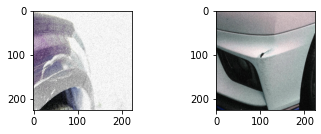

In [4]:
#Visualizing some of the images
plt.subplot(2,2,1)
plt.imshow(df['image'][0])
plt.subplot(2,2,2)
plt.imshow(df['image'][7199])

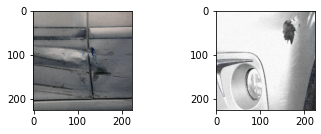

In [5]:
plt.subplot(2,2,1)
plt.imshow(df['image'][78])
plt.subplot(2,2,2)
plt.imshow(df['image'][935])

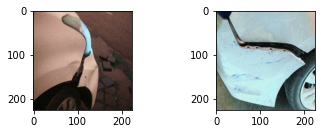

In [6]:
plt.subplot(2,2,1)
plt.imshow(df['image'][2000])
plt.subplot(2,2,2)
plt.imshow(df['image'][4590])

2    2349
4    2079
5    1185
6     882
3     534
1     171
Name: label, dtype: int64


<AxesSubplot:ylabel='label'>

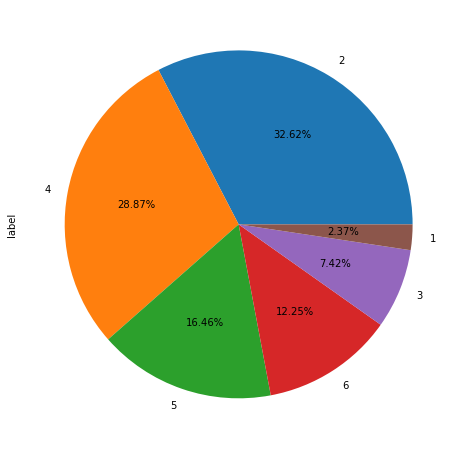

In [7]:
#Checking the distribution of target variable
print(df['label'].value_counts())
plt.figure(figsize=(20,8))
df['label'].value_counts().plot(kind='pie',autopct='%.2f%%')

The dataset is unbalanced as only 2.37% and 7.42% of the images are of class 1 and 3.

In [8]:
# Creating X_train and y_train

x = df['image']

print(x.shape)

(7200,)


In [9]:
# Reshaping x suitable for the model

x_train = []

for i, j in enumerate(x):
    x_train.append(j)

x_train= np.array(x_train, np.float32) / 255. # Converting the train data to an array and then normalizing it
x_train.shape

(7200, 224, 224, 3)

In [10]:
# Converting encoded 'breed' feature to categorical columns

y = df['label']

#y_train = tf.keras.utils.to_categorical(y, num_classes=None, dtype='int')
y_train = np.array(pd.get_dummies(y))
y_train.shape

(7200, 6)

In [11]:
# Reshaping x_test suitable for the model

x_test_data = df_test['image']
x_test = []

for i, j in enumerate(x_test_data):
    x_test.append(j)

x_test= np.array(x_test, np.float32) / 255. # Converting the train data to an array and then normalizing it
x_test.shape

(4800, 224, 224, 3)

### Model Building and Training

### Model1

In [12]:
from tensorflow.keras import backend
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(47)
import random
random.seed(47)
tf.random.set_seed(47)

In [13]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

base_model = MobileNet(input_shape=x_train[0].shape,
                       weights='imagenet',
                       include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x = base_model.output
x = GlobalAveragePooling2D()(x) # Optional
x = Dense(512,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x = Dropout(0.4)(x)
x = Dense(256,activation='relu')(x) #dense layer 2
x = Dropout(0.3)(x)
x = Dense(64,activation='relu')(x) #dense layer 3
preds = Dense(6,activation='softmax')(x) #final layer with softmax activation

model_mobilenet = Model(inputs=base_model.input,
                        outputs=preds)

# set the first 20 layers of the network to be non-trainable
for layer in model_mobilenet.layers[:20]:
    layer.trainable=False
for layer in model_mobilenet.layers[20:]:
    layer.trainable=True

# Compile the model
model_mobilenet.compile(optimizer='Adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

model_mobilenet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 16, 16, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 16, 16, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 16, 16, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 16, 16, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 16, 16, 32)        128   

                                                                 
 conv_dw_8 (DepthwiseConv2D  (None, 2, 2, 512)         4608      
 )                                                               
                                                                 
 conv_dw_8_bn (BatchNormali  (None, 2, 2, 512)         2048      
 zation)                                                         
                                                                 
 conv_dw_8_relu (ReLU)       (None, 2, 2, 512)         0         
                                                                 
 conv_pw_8 (Conv2D)          (None, 2, 2, 512)         262144    
                                                                 
 conv_pw_8_bn (BatchNormali  (None, 2, 2, 512)         2048      
 zation)                                                         
                                                                 
 conv_pw_8_relu (ReLU)       (None, 2, 2, 512)         0         
          

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1,mode='min', save_best_only=True, save_weights_only=True)

stop = EarlyStopping(monitor="val_loss", patience=6, mode='min')

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=4, min_lr=1e-6, verbose=1, mode='min')

In [ ]:
history1 = model_mobilenet.fit(x=x_train, 
                                  y=y_train, 
                                  batch_size=32, 
                                  epochs=30, 
                                  validation_split=0.2,verbose=1, callbacks=[checkpoint,reduce_lr,stop])

Epoch 1/30
180/180 [==============================] - ETA: 0s - loss: 1.5159 - accuracy: 0.4002
Epoch 1: val_loss improved from inf to 1.47907, saving model to model-1.48.h5
180/180 [==============================] - 80s 362ms/step - loss: 1.5159 - accuracy: 0.4002 - val_loss: 1.4791 - val_accuracy: 0.4313 - lr: 0.0010
Epoch 2/30
180/180 [==============================] - ETA: 0s - loss: 1.1446 - accuracy: 0.5410
Epoch 2: val_loss improved from 1.47907 to 1.05593, saving model to model-1.06.h5
180/180 [==============================] - 62s 347ms/step - loss: 1.1446 - accuracy: 0.5410 - val_loss: 1.0559 - val_accuracy: 0.5514 - lr: 0.0010
Epoch 3/30
180/180 [==============================] - ETA: 0s - loss: 0.9318 - accuracy: 0.6538
Epoch 3: val_loss improved from 1.05593 to 1.05505, saving model to model-1.06.h5
180/180 [==============================] - 64s 354ms/step - loss: 0.9318 - accuracy: 0.6538 - val_loss: 1.0550 - val_accuracy: 0.5597 - lr: 0.0010
Epoch 4/30
180/180 [=========

In [ ]:
## Accuracy and Loss plots

accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs   = range(len(accuracy)) # Get number of epochs

plt.plot  (epochs, accuracy, label = 'training accuracy')
plt.plot  (epochs, val_accuracy, label = 'validation accuracy')
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  (epochs, loss, label = 'training loss')
plt.plot  (epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')

In [22]:
#Saving the model
model_mobilenet.save('mobilenetmodel.h5')

C:\Anaconda\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
#Loading the model
mod = tf.keras.models.load_model('mobilenetmodel.h5')

In [25]:
#Prediction for train data
y_train_prob = mod.predict(x_train)
y_train_pred=np.argmax(y_train_prob,axis=1)
y_train_pred

225/225 [==============================] - 139s 610ms/step


array([1, 3, 1, ..., 3, 3, 1], dtype=int64)

In [33]:
#Printing the classification report for train data
from sklearn.metrics import classification_report
y_train = np.argmax(y_train,axis=1)
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       171
           1       0.99      0.97      0.98      2349
           2       0.99      0.99      0.99       534
           3       0.96      0.99      0.97      2079
           4       1.00      0.99      1.00      1185
           5       0.98      0.97      0.97       882

    accuracy                           0.98      7200
   macro avg       0.98      0.98      0.98      7200
weighted avg       0.98      0.98      0.98      7200



In [34]:
#Prediction for test data
y_test_prob = mod.predict(x_test)
y_test_pred = np.argmax(y_test_prob,axis=1)
y_test_pred

150/150 [==============================] - 98s 651ms/step


array([5, 3, 1, ..., 3, 1, 3], dtype=int64)

In [35]:
df_test

,image_id,filename,image
0,7201,7201.jpg,"[[[147, 151, 162], [134, 138, 149], [136, 140,..."
1,7202,7202.jpg,"[[[165, 153, 147], [155, 143, 137], [155, 143,..."
2,7203,7203.jpg,"[[[97, 109, 119], [93, 105, 115], [106, 121, 1..."
3,7204,7204.jpg,"[[[6, 4, 3], [10, 8, 7], [8, 6, 6], [9, 7, 7],..."
4,7205,7205.jpg,"[[[24, 40, 47], [27, 43, 50], [17, 33, 40], [3..."
...,...,...,...
4795,11996,11996.jpg,"[[[115, 115, 115], [134, 134, 134], [130, 130,..."
4796,11997,11997.jpg,"[[[94, 97, 102], [236, 239, 243], [236, 237, 2..."
4797,11998,11998.jpg,"[[[245, 245, 245], [244, 243, 247], [244, 243,..."
4798,11999,11999.jpg,"[[[14, 10, 9], [14, 9, 9], [10, 5, 5], [16, 12..."


In [36]:
df_test['label'] = y_test_pred

In [37]:
df_test

,image_id,filename,image,label
0,7201,7201.jpg,"[[[147, 151, 162], [134, 138, 149], [136, 140,...",5
1,7202,7202.jpg,"[[[165, 153, 147], [155, 143, 137], [155, 143,...",3
2,7203,7203.jpg,"[[[97, 109, 119], [93, 105, 115], [106, 121, 1...",1
3,7204,7204.jpg,"[[[6, 4, 3], [10, 8, 7], [8, 6, 6], [9, 7, 7],...",4
4,7205,7205.jpg,"[[[24, 40, 47], [27, 43, 50], [17, 33, 40], [3...",3
...,...,...,...,...
4795,11996,11996.jpg,"[[[115, 115, 115], [134, 134, 134], [130, 130,...",5
4796,11997,11997.jpg,"[[[94, 97, 102], [236, 239, 243], [236, 237, 2...",5
4797,11998,11998.jpg,"[[[245, 245, 245], [244, 243, 247], [244, 243,...",3
4798,11999,11999.jpg,"[[[14, 10, 9], [14, 9, 9], [10, 5, 5], [16, 12...",1


In [45]:
submission_df = df_test.loc[:,['image_id','label']]

In [49]:
submission_df.to_csv('sample_submission.csv',index=False)

### Moddel2

In [15]:
from tensorflow.keras import backend
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(50)
import random
random.seed(50)
tf.random.set_seed(50)

In [16]:
#Developing the model
model2 = tf.keras.models.Sequential()
#model2.add(tf.keras.Input(shape=(224,224,3)))
model2.add(tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same'))
model2.add(tf.keras.layers.MaxPool2D())
model2.add(tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same'))
model2.add(tf.keras.layers.MaxPool2D())
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(64,activation='relu',kernel_initializer='he_uniform'))
model2.add(tf.keras.layers.Dropout(0.4))
model2.add(tf.keras.layers.Dense(32,activation='relu',kernel_initializer='he_uniform'))
model2.add(tf.keras.layers.Dropout(0.4))
model2.add(tf.keras.layers.Dense(units=6,activation='softmax'))

In [17]:
model2.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [18]:
#compile the model
model2.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1,mode='min', save_best_only=True, save_weights_only=True)

stop = EarlyStopping(monitor="val_loss", patience=6, mode='min')

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=4, min_lr=1e-6, verbose=1, mode='min')

In [20]:
#Training the model
history2=model2.fit(x_train, y_train,
          validation_split=0.2,
          epochs=100,
          batch_size=32,verbose=1,callbacks=[checkpoint,reduce_lr,stop])

Epoch 1/100
180/180 [==============================] - ETA: 0s - loss: 1.7358 - accuracy: 0.3031
Epoch 1: val_loss improved from inf to 1.50672, saving model to model-1.51.h5
180/180 [==============================] - 190s 1s/step - loss: 1.7358 - accuracy: 0.3031 - val_loss: 1.5067 - val_accuracy: 0.3410 - lr: 0.0010
Epoch 2/100
180/180 [==============================] - ETA: 0s - loss: 1.4880 - accuracy: 0.3615
Epoch 2: val_loss improved from 1.50672 to 1.32308, saving model to model-1.32.h5
180/180 [==============================] - 179s 992ms/step - loss: 1.4880 - accuracy: 0.3615 - val_loss: 1.3231 - val_accuracy: 0.4646 - lr: 0.0010
Epoch 3/100
180/180 [==============================] - ETA: 0s - loss: 1.3464 - accuracy: 0.4264
Epoch 3: val_loss improved from 1.32308 to 1.23459, saving model to model-1.23.h5
180/180 [==============================] - 233s 1s/step - loss: 1.3464 - accuracy: 0.4264 - val_loss: 1.2346 - val_accuracy: 0.5292 - lr: 0.0010
Epoch 4/100
180/180 [========

KeyboardInterrupt: 

In [ ]:
## Accuracy and Loss plots

accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs   = range(len(accuracy)) # Get number of epochs

plt.plot  (epochs, accuracy, label = 'training accuracy')
plt.plot  (epochs, val_accuracy, label = 'validation accuracy')
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  (epochs, loss, label = 'training loss')
plt.plot  (epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')

### Model3

In [12]:
# Import required libraries

import tensorflow
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2,preprocess_input as resnet_preprocess
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input as inception_preprocess
from tensorflow.keras.applications.xception import Xception , preprocess_input as xception_preprocess
from tensorflow.keras.applications.nasnet import NASNetLarge,preprocess_input as nasnet_preprocess
from tensorflow.keras.layers import BatchNormalization,Dense,GlobalAveragePooling2D,Lambda,Dropout,InputLayer,Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model

In [13]:
# Setting the shapes of input for using pre-trained model

input_shape=(224,224,3)
input_layer=Input(shape=(input_shape))

In [14]:
# Model Buiulding

# Inception_ResNet model
preprocess_resnet=Lambda(resnet_preprocess)(input_layer)
inception_resnet=InceptionResNetV2(weights='imagenet',include_top=False,
                                   input_shape=input_shape,pooling='avg')(preprocess_resnet)


# InceptionV3 model
preprocessor_inception=Lambda(inception_preprocess)(input_layer)
inception_v3=InceptionV3(weights='imagenet',include_top=False,
                                   input_shape=input_shape,pooling='avg')(preprocessor_inception)


# Xception model
preprocessor_xception=Lambda(xception_preprocess)(input_layer)
xception=Xception(weights='imagenet',include_top=False,
                                   input_shape=input_shape,pooling='avg')(preprocessor_xception)


# NASNetLarge model
preprocessor_nasnet=Lambda(nasnet_preprocess)(input_layer)
nasnet=NASNetLarge(weights='imagenet',include_top=False,
                                   input_shape=input_shape,pooling='avg')(preprocessor_nasnet)

In [15]:
# Mergining 4 models all together for predicting and extracting the features

merge=concatenate([inception_resnet,inception_v3,xception,nasnet])
model=Model(inputs=input_layer,outputs=merge)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 lambda_1 (Lambda)           (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 lambda_2 (Lambda)           (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                              

In [46]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
print(model.input.shape)
print(model.output.shape)
print(len(model.trainable_weights))

(None, 224, 224, 3)
(None, 9664)
1846


In [17]:
# Adding all the train image paths under filename

data['file_path']=data['image_id'].apply(lambda x: 'E:/Data Science/Damaged Vehicle Classification/train'+'/'+f"{x}.jpg")
data.head()

,image_id,filename,label,file_path
0,1,1.jpg,2,E:/Data Science/Damaged Vehicle Classification...
1,2,2.jpg,4,E:/Data Science/Damaged Vehicle Classification...
2,3,3.jpg,2,E:/Data Science/Damaged Vehicle Classification...
3,4,4.jpg,3,E:/Data Science/Damaged Vehicle Classification...
4,5,5.jpg,5,E:/Data Science/Damaged Vehicle Classification...


In [31]:
# Feature extraction using pre-trained model

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

def feature_extractor(df):
    img_size = (224,224,3)
    data_size = len(df)
    batch_size = 32     # Random value, can be varied as per the requirement
    x = np.zeros([data_size,9664]) # Output layer of the merged model has 9664 classes

    # Extracting the features of all the images which was saved under file_name in the dataframe(labels)
    datagen = ImageDataGenerator()
    generator = datagen.flow_from_dataframe(df,x_col = 'file_path', class_mode = None, batch_size=batch_size, 
                                            shuffle = False,target_size = (img_size[:2]),color_mode = 'rgb')    
    
    i = 0
    
    for input_batch in tqdm(generator):
        input_batch = model.predict(input_batch)
        x[i * batch_size : (i + 1) * batch_size] = input_batch # Based on the batch size the predicted output(input_batch) is stored in batches in 'x'
        i += 1
        if i * batch_size >= data_size:    # Stop when it reaches the last row(10222) in the dataframe
            break
    return x # Returning the extracted features

In [19]:
# Extracting the features to be applied for model training
X = feature_extractor(data)

Found 0 validated image filenames.


C:\Anaconda\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 7200 invalid image filename(s) in x_col="file_path". These filename(s) will be ignored.
  warnings.warn(
0it [00:00, ?it/s]


ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [ ]:
# label encoding the target variable 'breed'Adam

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(data['label'])
print(integer_encoded)

In [ ]:
# Converting encoded 'breed' feature to categorical columns

y = tensorflow.keras.utils.to_categorical(integer_encoded, num_classes=None, dtype='int')
y

In [ ]:
# Setting up Early stopping and model checkpoint 

from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

earlystop=EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True)
checkpoint=ModelCheckpoint('checkpoint',monitor='val_loss',mode='min',save_best_only=True)
lr=ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=3,min_lr=1e-6)
my_callback=[earlystop,checkpoint,lr]

In [ ]:
# Model defenition and compilation

model_merged =tensorflow.keras.models.Sequential([InputLayer(X.shape[1:]),
                                          Dropout(0.7),
                                          Dense(120,activation='softmax')])

model_merged.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# Model Fitting

model_history = model_merged.fit(X,y,batch_size=120,epochs=100,validation_split=0.20,callbacks=my_callback)

In [60]:
len(data)

7200

In [21]:
np.arange(0, 1000, 5).shape

(200,)

In [25]:
np.expand_dims(np.arange(0, 1000, 5),axis=1).shape

(200, 1)

In [26]:
img_size = (224,224,3)
data_size = len(df)
batch_size = 32     # Random value, can be varied as per the requirement
x = np.zeros([data_size,9664])

In [29]:
len(x)

7200

In [32]:
t =feature_extractor(df)

TypeError: All values in column x_col=image must be strings.

In [ ]:
datagen = ImageDataGenerator()
    generator = datagen.flow_from_dataframe(df,x_col = 'file_path', class_mode = None, batch_size=batch_size, 
                                            shuffle = False,target_size = (img_size[:2]),color_mode = 'rgb')    
    
    i = 0
    
    for input_batch in tqdm(generator):
        input_batch = model.predict(input_batch)
        x[i * batch_size : (i + 1) * batch_size] = input_batch # Based on the batch size the predicted output(input_batch) is stored in batches in 'x'
        i += 1
        if i * batch_size >= data_size:    # Stop when it reaches the last row(10222) in the dataframe
            break
    return x # Returning the extracted features

In [33]:
model.predict(x_train)

  8/225 [>.............................] - ETA: 1:18:01

KeyboardInterrupt: 